In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
etth1data = pd.read_csv('dataset/ETT-small/ETTh1.csv')
etth1data = etth1data.drop('date', axis=1)
target = etth1data.pop('OT')
etth1data.insert(0, 'OT', target)
data1 = etth1data
# pcmci_result = np.array([8, -1, 10, -1, 11,  4, 16, 20, 14, -1, 19, 13, -1,  9, 13,  7, 10,
#                             -1, 17, 17,  3, 16,  0, 16, 13])
pcmci_result = np.array([1, 1, 3, 1, 3, 2, 1]).astype(int)

In [12]:
etth2data = pd.read_csv('dataset/ETT-small/ETTh2.csv')
etth2data = etth2data.drop('date', axis=1)
target = etth2data.pop('OT')
etth2data.insert(0, 'OT', target)
data1 = etth2data
pcmci_result = np.array([1, 1, 1, 1, 1, 1, 1]).astype(int)

In [2]:
ettm1data = pd.read_csv('dataset/ETT-small/ETTm1.csv')
ettm1data = ettm1data.drop('date', axis=1)
target = ettm1data.pop('OT')
ettm1data.insert(0, 'OT', target)
data1 = ettm1data
pcmci_result = np.array([1, 1, 1, 1, 1, 1, 1]).astype(int)

In [2]:
ettm2data = pd.read_csv('dataset/ETT-small/ETTm2.csv')
ettm2data = ettm2data.drop('date', axis=1)
target = ettm2data.pop('OT')
ettm2data.insert(0, 'OT', target)
data1 = ettm2data
pcmci_result = np.array([1, 1, 1, 1, 1, 1, 1]).astype(int)

In [2]:
exchangedata = pd.read_csv('dataset/exchange_rate/exchange_rate.csv')
exchangedata = exchangedata.drop('date', axis=1)
target = exchangedata.pop('OT')
exchangedata.insert(0, 'OT', target)
data1 = exchangedata
pcmci_result = np.array([1, -1, 3, 5, 3, -1, 1, 1]).astype(int)

In [2]:
metrodata = pd.read_csv('dataset/Metro_Interstate_Traffic_Volume.csv').drop(['weather_description', 'date_time'], axis=1)
target = metrodata.pop('traffic_volume')
metrodata.insert(0, 'OT', target)
metrodata.loc[metrodata['holiday'] == 'None', 'holiday'] = 0
metrodata.loc[metrodata['holiday'] != 0, 'holiday'] = 1
metrodata['holiday'] = metrodata['holiday'].astype('int64')
metrodata['weather_main'] = metrodata['weather_main'].map({'Clouds':0. , 'Clear':1., 'Rain':2., 'Drizzle':3., 'Mist':4., 'Haze':5., 'Fog':6.,
                                                            'Thunderstorm':7., 'Snow':8., 'Squall':9., 'Smoke':10.})
data1 = metrodata
pcmci_result = np.array([1, 1, 1, 1, 1, 1, 1]).astype(int)

In [2]:
pmdata = pd.read_csv('dataset/beijing_air.csv')
pmdata['date'] = pd.to_datetime(pmdata['date'])
pmdata['year'] = pmdata['date'].apply(lambda x:x.year)
pmdata['month'] = pmdata['date'].apply(lambda x:x.month)
pmdata['day'] = pmdata['date'].apply(lambda x:x.day)
pmdata['hour'] = pmdata['date'].apply(lambda x:x.hour)
pmdata = pmdata.drop(['date', 'wnd_dir'], axis=1)
pmdata.dtypes

data1 = pmdata
pcmci_result = np.array([1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1]).astype(int)

In [3]:
sorted_data = data1.iloc[:, pcmci_result > -1]

sorted_arrows = pcmci_result[pcmci_result > -1].astype(int)

tau_max = 20
ar_range = 10

lagged_data = pd.DataFrame(sorted_data.iloc[tau_max:, 0])
for i in range(1, ar_range):
    lagged_data['OT' + '_' + str(i)] = np.array(sorted_data.iloc[tau_max-i:-i, 0])
for i in range(sorted_data.shape[1]):
    if sorted_arrows[i] == 0:
        lagged_data[sorted_data.columns[i] + '_' + str(sorted_arrows[i])] = np.array(sorted_data.iloc[tau_max:, i])
        continue
    lagged_data[sorted_data.columns[i] + '_' + str(sorted_arrows[i])] = np.array(sorted_data.iloc[tau_max - sorted_arrows[i]:-sorted_arrows[i], i])

minmaxgap =  lagged_data.iloc[:, 0].max() - lagged_data.iloc[:, 0].min()

lagged_data = (lagged_data - lagged_data.min()) / ( lagged_data.max() - lagged_data.min())

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

class Mine(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

class Z_RNN(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32, num_layers = 1, output_size = 2):
        super(Z_RNN, self).__init__()

        self.rnn = nn.RNN(
            input_size = input_size,
            hidden_size = hidden_size,     # rnn hidden unit
            num_layers = num_layers,       # number of rnn layer
            batch_first = True,   # input & output will has batch size as 1s dimension. e.g. (batch, time_step, input_size)
        )
        self.out = nn.Linear(hidden_size, output_size)

    def forward(self, x, h_state):
        r_out, h_state = self.rnn(x, h_state)
        # print(r_out.shape)
        # outs = []    # save all predictions
        # for time_step in range(r_out.size(1)):    # calculate output for each time step
        #     outs.append(self.out(r_out[:, time_step, :]))

        # return torch.stack(outs, dim=1), h_state

        outs = self.out(r_out)
        return outs, h_state

class Regressor(nn.Module):
    def __init__(self, input_size = 2, hidden_size = 32):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1)
        nn.init.normal_(self.fc1.weight,std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight,std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight,std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        output = F.relu(self.fc1(input))
        output = F.relu(self.fc2(output))
        output = self.fc3(output)
        return output

/home/dell/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
data2 = lagged_data.copy()
data = np.array(data2)
data.shape

train_proportion = 0.6
valid_proportion = 0.2
test_proportion = 0.2

train_size = int(data.shape[0] * train_proportion)
valid_size = int(data.shape[0] * valid_proportion)

train_data = data[:train_size]
valid_data = data[train_size:train_size+valid_size]
test_data = data[train_size+valid_size:]

batch_size = 20
window_size = 400

z_size = data.shape[1]

In [5]:
mine_net = Mine(input_size = data.shape[1]+z_size, hidden_size = 512).cuda()
mine_net_optim = optim.Adam(mine_net.parameters(), lr = 1e-4, weight_decay = 1e-5)
zrnn_net = Z_RNN(input_size = data.shape[1], hidden_size = 256, num_layers = 2, output_size = z_size).cuda()
zrnn_net_optim = optim.Adam(zrnn_net.parameters(), lr = 1e-4, weight_decay = 1e-5)
h_state = torch.zeros((2, data.shape[1]*2))
h_state = h_state.to('cuda:0')

In [6]:
def mutual_information(joint_X, marginal_X, Y,
                        mine_net, zrnn_net, h_state):
    h_state = None
    Z, h_state = zrnn_net(torch.cat((joint_X, Y), axis = 1), h_state)
    t = mine_net( torch.cat((joint_X, Y, Z), axis = 1) )
    marginal_t = mine_net( torch.cat((marginal_X, Y, Z), axis = 1) )
    et = torch.exp(marginal_t)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et, h_state

def learn_mine(X, Y, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim,
                h_state, ma_et,
                batch_size = 100, window_size = 100, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    X_all = X
    Y_all = Y
    loss = 0
    # for _ in range(batch_size):
    pivot = 0
    pivot = np.random.randint(X_all.shape[0]-window_size)
    X = X_all[pivot:pivot+window_size]
    Y = Y_all[pivot:pivot+window_size]
    # index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    index = np.random.choice(range(X.shape[0]), size=window_size, replace=False)
    marginal_X = X[index]
    # marginal_X = marginal_X[pivot:pivot+window_size]

    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

    h_state = None

    mi_lb, t, et, h_state = mutual_information(X, marginal_X, Y,
                                                mine_net, zrnn_net, h_state)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)

# unbiasing use moving average
    loss = (-(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et)) )
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    zrnn_net_optim.zero_grad()
    autograd.backward(loss)
    # nn.utils.clip_grad_norm(mine_net.parameters(), max_norm=0.1, norm_type=2)
    # nn.utils.clip_grad_norm(zrnn_net.parameters(), max_norm=0.1, norm_type=2)
    mine_net_optim.step()
    zrnn_net_optim.step()
    return mi_lb, ma_et, loss, h_state

def train(train_data, valid_data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim,
            h_state, result, loss, ma_et, batch_size=100, window_size=100,
            iter_num=int(10e+3) , log_freq=int(1e+3)):

    train_best_result = 0
    valid_best_result = 10000
    early_stop_count = 0

    for i in tqdm(range(iter_num)):
        # 1. train zrnn + mine
        X = np.expand_dims(train_data[:, 0], 1)
        Y = train_data[:, 1:]
        if Y.ndim == 1:
            Y = np.expand_dims(Y, 1)
        mi_lb, ma_et, loss_, h_state = learn_mine(X, Y, mine_net, mine_net_optim, 
                                                    zrnn_net, zrnn_net_optim,
                                                    h_state, ma_et, batch_size, window_size)
        # h_state = h_state.data
        
        if mi_lb > train_best_result:
            train_best_result = mi_lb
            torch.save(zrnn_net.state_dict(), 'zrnn_net.pt')
            torch.save(mine_net.state_dict(), 'mine_net.pt')

        result.append(mi_lb.detach().cpu().numpy())
        loss.append(loss_.detach().cpu().numpy())

    return result, loss, ma_et, train_best_result

In [7]:
result = list()
loss = list()
ma_et = 1.

In [8]:
result, loss, ma_et, best_result = train(train_data, valid_data, mine_net, mine_net_optim,
                                            zrnn_net, zrnn_net_optim,
                                            h_state, result, loss, ma_et,
                                            batch_size=batch_size, window_size=window_size,
                                            iter_num=int(500000), log_freq=int(1e+4))

100%|██████████| 500000/500000 [1:48:17<00:00, 76.95it/s]  


In [9]:
best_result

tensor(11.2368, device='cuda:0', grad_fn=<SubBackward0>)

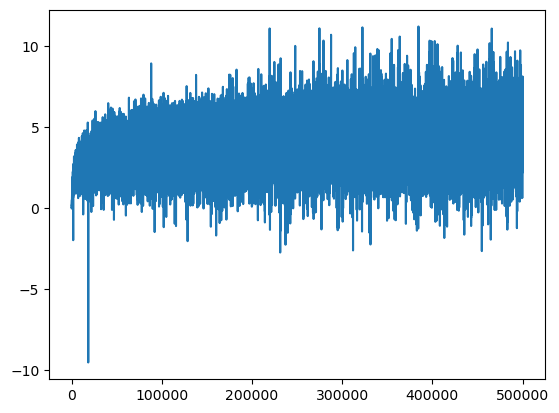

In [10]:
def ma(a, window_size=100):
    return [np.mean(a[i:i+window_size]) for i in range(0,len(a)-window_size)]


result_cor_ma = ma(result)
# print(result_cor_ma[-1])
plt.plot(result)
# plt.plot(result_cor_ma)
# plt.plot(range(200, 1300), result_cor_ma[200:1300])

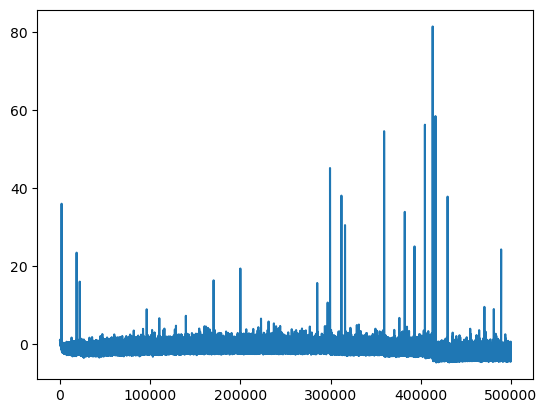

In [11]:
plt.plot(loss)

In [12]:
def generate_Z(data, zrnn_net):
    h_state = None
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]

    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    marginal_X = X[index]
    h_state = None

    Z, h_state = zrnn_net(torch.cat((X, Y), axis = 1), h_state)
    Z = Z.detach().cpu().numpy()

    return Z

In [13]:
Z = generate_Z(data, zrnn_net)
Z = (Z - Z.min())/(Z.max() - Z.min())

In [14]:
# Z_spare = Z
# Z = np.load('results/original_etth1_z.npy')
np.save('results/original_pm_z.npy', Z)

In [20]:
train_Z = Z[:train_size]
valid_Z = Z[train_size:train_size+valid_size]
test_Z = Z[train_size+valid_size:]

In [21]:
def train_reg(data, Z, regr_net, regr_net_optim, iter_num = 5000):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    # X_lagged = np.concatenate((np.ones(shape=(1,1), dtype=np.float)*data[0,0], np.expand_dims((data[0:-1:, 0]), 0)), 1)
    # Y = np.concatenate((X_lagged.T, data[:, 1:]), 1)
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    Z = torch.autograd.Variable(torch.FloatTensor(Z)).cuda()

    best_result = 1000
    loss_array = []
    for _ in tqdm(range(iter_num)):
        X_pred = regr_net(torch.cat((Y, Z), axis = 1))
        mseloss = torch.nn.MSELoss(reduction = 'mean')
        loss = mseloss(X_pred, X)
        regr_net_optim.zero_grad()
        autograd.backward(loss)
        nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
        regr_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())

        if loss < best_result:
            best_result = loss
            torch.save(regr_net.state_dict(), 'regr_net.pt')
    
    return loss_array, X_pred.detach().cpu().numpy()

In [22]:
def train_reg_withoutZ(data, regr_net, regr_net_optim, iter_num = 5000):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()

    best_result = 1000
    loss_array = []
    for _ in tqdm(range(iter_num)):
        X_pred = regr_net(Y)
        mseloss = torch.nn.MSELoss(reduction = 'mean')
        loss = mseloss(X_pred, X)
        regr_net_optim.zero_grad()
        autograd.backward(loss)
        nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
        regr_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())

        if loss < best_result:
            best_result = loss
            torch.save(regr_net.state_dict(), 'regr_net.pt')
    
    return loss_array, X_pred.detach().cpu().numpy()

In [23]:
regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
regr_net_without_Z_optim = optim.Adam(regr_net_without_Z.parameters(), lr = 1e-3, weight_decay = 1e-5)
loss_array, train_X_pred_without_Z = train_reg_withoutZ(train_data, regr_net_without_Z, regr_net_without_Z_optim, iter_num = 50000)

regr_without_Z_trained = regr_net_without_Z
regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
regr_net_without_Z.load_state_dict(torch.load('regr_net.pt'))

  0%|          | 0/50000 [00:00<?, ?it/s]

/tmp/ipykernel_1181035/1729585600.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 50000/50000 [02:43<00:00, 305.70it/s]


<All keys matched successfully>

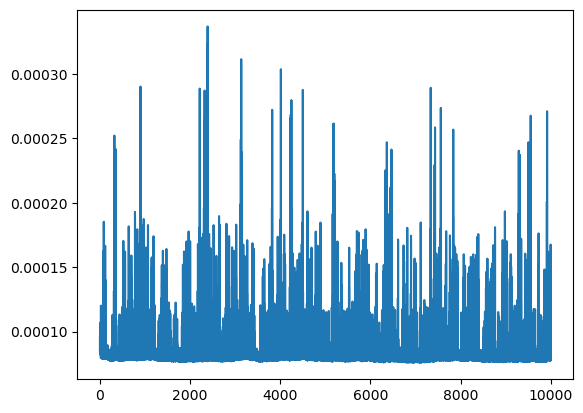

In [24]:
plt.plot(loss_array[-10000:])

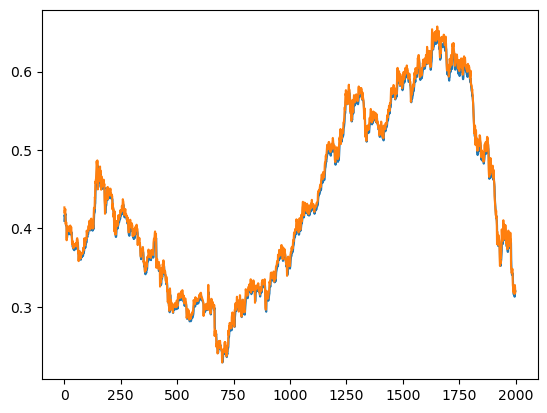

In [25]:
# plt.plot(train_X_pred_without_Z)
# plt.plot(train_data[:,0])
plt.plot(train_X_pred_without_Z[:2000])
plt.plot(train_data[:2000,0])

In [26]:
def test(data, Z, regr_net):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    Z = torch.autograd.Variable(torch.FloatTensor(Z)).cuda()
    
    X_pred = regr_net(torch.cat((Y, Z), axis = 1))
    mseloss = torch.nn.MSELoss(reduction = 'sum')
    loss = mseloss(X_pred, X)
    return loss.detach(), X_pred.detach().cpu().numpy()

In [27]:
regr_net = Regressor(input_size = data.shape[1]-1+z_size, hidden_size = z_size * 4).cuda()
regr_net_optim = optim.Adam(regr_net.parameters(), lr = 1e-3, weight_decay = 1e-5)
# loss_array, train_X_pred = train_reg(train_data, train_Z, regr_net, regr_net_optim, iter_num = 50000)
loss_array, valid_X_pred = train_reg(valid_data, valid_Z, regr_net, regr_net_optim, iter_num = 50000)

regr_trained = regr_net
regr_net = Regressor(input_size = data.shape[1]-1+z_size, hidden_size = z_size * 4).cuda()
regr_net.load_state_dict(torch.load('regr_net.pt'))

test_loss, X_pred = test(test_data, test_Z, regr_net)
MSEloss = np.mean(np.square(test_data[10:,0] - X_pred[10:].T))# * minmaxgap

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_1181035/3979216300.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 50000/50000 [02:41<00:00, 308.91it/s]


In [28]:
MSEloss

9.909744338695167e-05

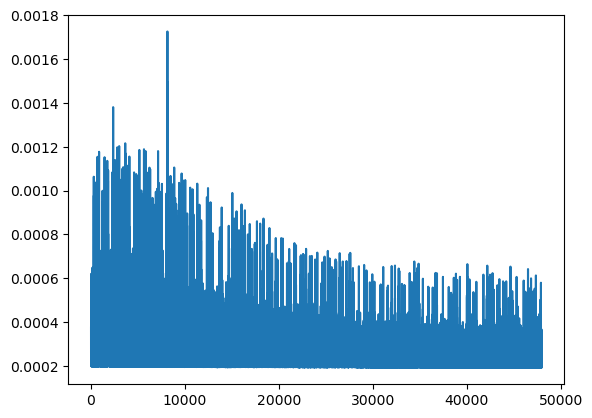

In [29]:
plt.plot(loss_array[-48000:])

In [30]:
MSEloss

9.909744338695167e-05

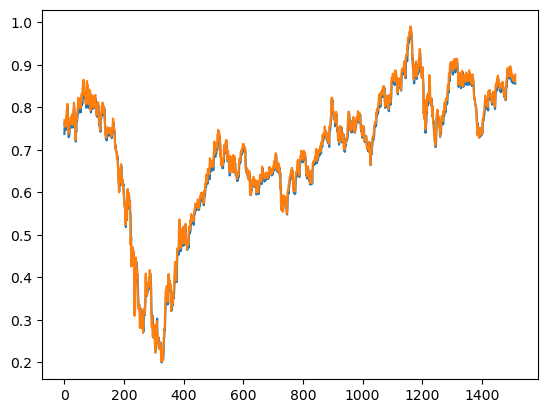

In [31]:
# plt.plot(train_X_pred)
# plt.plot(train_data[:,0])
# plt.plot(train_X_pred[:2000, ])
# plt.plot(train_data[:2000,0])
plt.plot(valid_X_pred)
plt.plot(valid_data[:,0])

In [32]:
min_loss = 1000
for i in range(10):
    regr_net = Regressor(input_size = data.shape[1]-1+z_size, hidden_size = z_size * 4).cuda()
    regr_net_optim = optim.Adam(regr_net.parameters(), lr = 1e-3, weight_decay = 1e-5)
    loss_array, train_X_pred = train_reg(train_data, train_Z, regr_net, regr_net_optim, iter_num = 50000)
    # loss_array, train_X_pred = train_reg(valid_data, valid_Z, regr_net, regr_net_optim, iter_num = 50000)

    regr_trained = regr_net
    regr_net = Regressor(input_size = data.shape[1]-1+z_size, hidden_size = z_size * 4).cuda()
    regr_net.load_state_dict(torch.load('regr_net.pt'))

    test_loss, X_pred = test(test_data, test_Z, regr_net)
    MSEloss = np.mean(np.square(test_data[10:,0] - X_pred[10:].T))# * minmaxgap
    if MSEloss < min_loss:
        min_loss = MSEloss

min_loss

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_1181035/3979216300.py:18: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 50000/50000 [02:39<00:00, 313.23it/s]


9.667252884406171e-05

In [33]:
min_loss

9.667252884406171e-05

In [34]:
def test_without_Z(data, regr_net):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()

    X_pred = regr_net(Y)
    mseloss = torch.nn.MSELoss(reduction = 'sum')
    loss = mseloss(X_pred, X)
    return loss.detach(), X_pred.detach().cpu().numpy()

In [35]:
min_loss = 1000
for i in range(10):
    regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
    regr_net_without_Z_optim = optim.Adam(regr_net_without_Z.parameters(), lr = 1e-3, weight_decay = 1e-5)
    loss_array, train_X_pred_without_Z = train_reg_withoutZ(train_data, regr_net_without_Z, regr_net_without_Z_optim, iter_num = 50000)
    # loss_array, train_X_pred_without_Z = train_reg_withoutZ(valid_data, regr_net_without_Z, regr_net_without_Z_optim, iter_num = 50000)

    regr_without_Z_trained = regr_net_without_Z
    regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
    regr_net_without_Z.load_state_dict(torch.load('regr_net.pt'))

    test_loss, X_pred_without_Z = test_without_Z(test_data, regr_net_without_Z)
    MSEloss = np.mean(np.square(test_data[:,0] - X_pred_without_Z[:].T))# * minmaxgap
    if MSEloss < min_loss:
        min_loss = MSEloss

min_loss

  0%|          | 0/50000 [00:00<?, ?it/s]/tmp/ipykernel_1181035/1729585600.py:15: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 50000/50000 [02:57<00:00, 282.09it/s]


9.948066374760255e-05

In [36]:
min_loss

9.948066374760255e-05

In [48]:
test_loss, X_pred_without_Z = test_without_Z(test_data, regr_net_without_Z)
MSEloss = np.mean(np.square(test_data[:,0] - X_pred_without_Z[:].T))# * minmaxgap
MSEloss

0.00016576672922772112

In [49]:
MSEloss = np.mean(np.square(test_data[1:,0] - test_data[:-1,0]))# * minmaxgap
MSEloss

8.919050102218905e-05

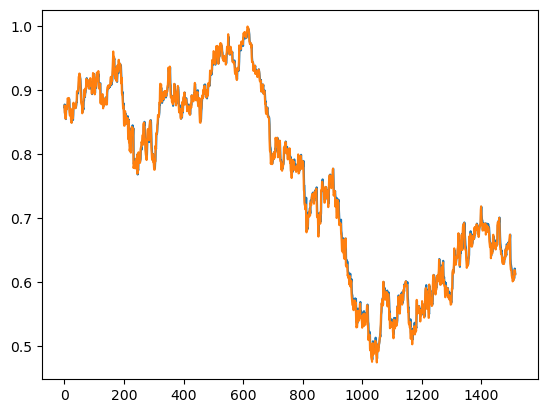

In [50]:
plt.plot(X_pred[:])
plt.plot(test_data[:,0])

In [100]:
def mutual_information_explicit(joint_X, marginal_X, Y, mine_net):
    t = mine_net( torch.cat((joint_X, Y), axis = 1) )
    marginal_t = mine_net( torch.cat((marginal_X, Y), axis = 1) )

    # Z, h_state = zrnn_net( torch.cat((joint_X[:-1, :], Y[:-1, :]), 1), h_state)
    # t = mine_net( torch.cat((joint_X[1:, :], Y[1:, :], Z), axis = 1) )
    # marginal_t = mine_net( torch.cat((marginal_X[1:, :], Y[1:, :], Z), axis = 1) )

    et = torch.exp(marginal_t)
    mi_lb = torch.mean(t) - torch.log(torch.mean(et))
    return mi_lb, t, et

def learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et, ma_rate=0.01):
    # batch is a tuple of (joint, marginal)
    index = np.random.choice(range(X.shape[0]), size=X.shape[0], replace=False)
    marginal_X = X[index]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    marginal_X = torch.autograd.Variable(torch.FloatTensor(marginal_X)).cuda()

    mi_lb, t, et = mutual_information_explicit(X, marginal_X, Y, mine_net)
    ma_et = (1-ma_rate)*ma_et + ma_rate*torch.mean(et)
    
    # unbiasing use moving average
    loss = -(torch.mean(t) - (1/ma_et.mean()).detach()*torch.mean(et))
    # use biased estimator
#     loss = - mi_lb
    
    mine_net_optim.zero_grad()
    autograd.backward(loss)
    mine_net_optim.step()
    return mi_lb, ma_et, loss

In [101]:
def train_explicit(data, mine_net, mine_net_optim, batch_size=100, iter_num=int(1e+3) , log_freq=int(1e+2)):
# def train(data, mine_net, mine_net_optim, zrnn_net, zrnn_net_optim, h_state, batch_size=100, iter_num=3000, log_freq=int(1e+2)):
    # data is x or y
    result = list()
    loss = list()
    ma_et = 1.
    for i in tqdm(range(iter_num)):
        X = np.expand_dims(data[:, 0], 1)
        Y = data[:, 1:]
        # Y = np.expand_dims(data[:, 0], 1)
        if Y.ndim == 1:
            Y = np.expand_dims(Y, 1)

        mi_lb, ma_et, l = learn_mine_explicit(X, Y, mine_net, mine_net_optim, ma_et)
        # if (i+1)%(10)==0:
        result.append(mi_lb.detach().cpu().numpy())
        loss.append(l.detach().cpu().numpy())
        if (i+1)%(log_freq)==0:
            print(result[-1])
    return result, loss

In [102]:
mine_net_explicit = Mine(input_size = data.shape[1], hidden_size = 512).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_explicit = train_explicit(train_data, mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

 10%|█         | 10011/100000 [02:16<20:50, 71.97it/s]

1.8619697


 20%|██        | 20009/100000 [04:32<17:50, 74.75it/s]

2.030606


 30%|███       | 30010/100000 [06:49<15:22, 75.89it/s]

2.1319544


 40%|████      | 40014/100000 [09:05<13:09, 75.98it/s]

2.2634463


 50%|█████     | 50009/100000 [11:21<11:40, 71.38it/s]

2.2955139


 60%|██████    | 60015/100000 [13:38<09:00, 73.94it/s]

2.3492603


 70%|███████   | 70009/100000 [15:55<06:48, 73.46it/s]

2.3747838


 80%|████████  | 80009/100000 [18:10<04:26, 74.97it/s]

2.2697828


 90%|█████████ | 90007/100000 [20:25<02:10, 76.45it/s]

2.511119


100%|██████████| 100000/100000 [22:34<00:00, 73.80it/s]


2.5120118


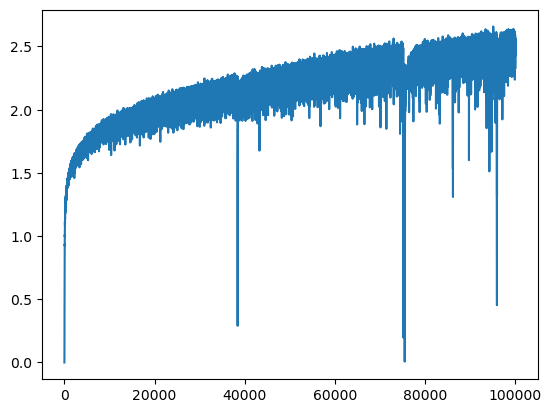

In [103]:
# plt.plot(range(len(ma(result_explicit))), ma(result_explicit))
plt.plot(result_explicit[0])

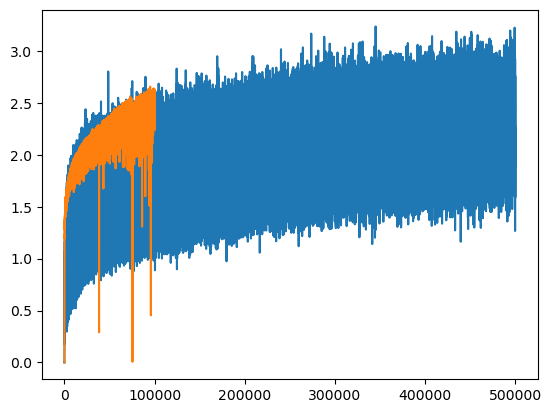

In [105]:
plt.plot(result)
plt.plot(result_explicit[0])

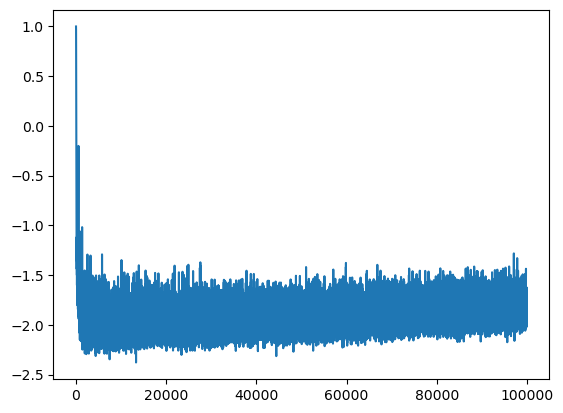

In [318]:
plt.plot(result_explicit[1])

In [106]:
mine_net_explicit_plus_Z = Mine(input_size = data.shape[1]+z_size, hidden_size = 512).cuda()
mine_net_explicit_plus_Z_optim = optim.Adam(mine_net_explicit_plus_Z.parameters(),
                                            lr=1e-3, weight_decay = 1e-5)
result_explicit_plus_Z = train_explicit(np.concatenate((train_data, train_Z), axis=1),
                                        mine_net_explicit_plus_Z, mine_net_explicit_plus_Z_optim,
                                        batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

  0%|          | 0/100000 [00:00<?, ?it/s]

 10%|█         | 10007/100000 [02:29<21:45, 68.94it/s]

1.9755644


 20%|██        | 20010/100000 [04:56<19:29, 68.38it/s]

2.122621


 30%|███       | 30014/100000 [07:23<15:50, 73.62it/s]

2.2169259


 40%|████      | 40010/100000 [09:55<16:15, 61.52it/s]

2.387099


 50%|█████     | 50010/100000 [12:30<13:32, 61.55it/s]

2.360812


 60%|██████    | 60009/100000 [15:06<09:54, 67.30it/s]

2.4093761


 70%|███████   | 70010/100000 [17:42<07:34, 65.96it/s]

2.5514102


 80%|████████  | 80008/100000 [20:17<05:04, 65.64it/s]

2.1565466


 90%|█████████ | 90013/100000 [22:49<02:32, 65.66it/s]

2.6015007


100%|██████████| 100000/100000 [25:14<00:00, 66.02it/s]


2.5764937


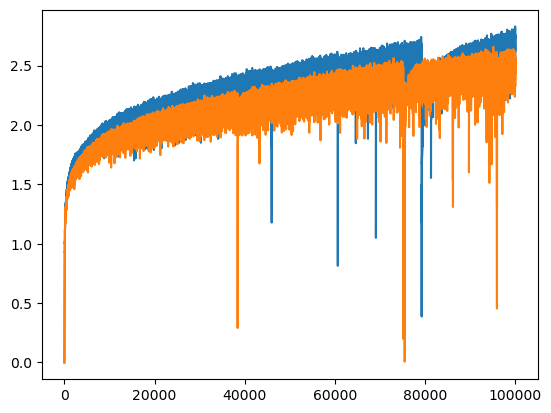

In [108]:
plt.plot(result_explicit_plus_Z[0])
plt.plot(result_explicit[0])

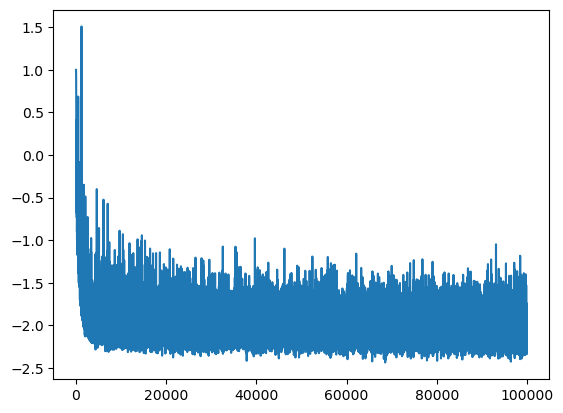

In [413]:
plt.plot(result_explicit_plus_Z[1])

In [130]:
# mine_net_explicit = Mine(input_size = data.shape[1]) #.cuda()
mine_net_explicit = Mine(input_size = 2).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_entropy = train_explicit(np.concatenate((np.expand_dims(train_data[:, 0], 1), (np.expand_dims(train_data[:, 0], 1))), 1), mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

 10%|█         | 10026/100000 [01:09<09:38, 155.57it/s]

5.5123687


 20%|██        | 20030/100000 [02:21<09:16, 143.83it/s]

5.600969


 30%|███       | 30029/100000 [03:32<07:34, 153.85it/s]

4.5534906


 40%|████      | 40028/100000 [04:44<07:23, 135.33it/s]

5.9385295


 50%|█████     | 50015/100000 [05:56<06:01, 138.14it/s]

5.719413


 60%|██████    | 60017/100000 [07:08<05:12, 128.10it/s]

6.72899


 70%|███████   | 70028/100000 [08:21<03:30, 142.15it/s]

6.2774653


 80%|████████  | 80017/100000 [09:34<02:32, 130.86it/s]

6.6623726


 90%|█████████ | 90026/100000 [10:47<00:59, 168.98it/s]

6.4303427


100%|██████████| 100000/100000 [11:58<00:00, 139.27it/s]


6.6305847


In [117]:
def train_reg_withoutZ(data, regr_net, regr_net_optim, window_size, iter_num = 5000):
    X = np.expand_dims(data[:, 0], 1)
    Y = data[:, 1:]
    X = torch.autograd.Variable(torch.FloatTensor(X)).cuda()
    Y = torch.autograd.Variable(torch.FloatTensor(Y)).cuda()
    pivot = np.random.randint(X.shape[0]-window_size)
    X = X[pivot:pivot+window_size]
    Y = Y[pivot:pivot+window_size]

    loss_array = []
    for _ in tqdm(range(iter_num)):
        h_state = None
        # X_pred = regr_net(Y)
        X_pred, h_state = regr_net(Y, h_state)
        mseloss = torch.nn.MSELoss(reduction = 'sum')
        loss = mseloss(X_pred, X)
        regr_net_optim.zero_grad()
        autograd.backward(loss)
        nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
        regr_net_optim.step()
        loss_array.append(loss.detach().cpu().numpy())
    
    return loss_array, X_pred.detach().cpu().numpy()

# regr_net_without_Z = Regressor(input_size = data.shape[1]-1, hidden_size = data.shape[1] * 4).cuda()
regr_net_without_Z = Z_RNN(input_size = train_data.shape[1]-1, hidden_size = train_data.shape[1]*4, num_layers = 2, output_size = 1).cuda()
regr_net_without_Z_optim = optim.Adam(regr_net_without_Z.parameters(), lr = 5e-4, weight_decay = 1e-5)
loss_array, train_X_pred_without_Z = train_reg_withoutZ(train_data, regr_net_without_Z, regr_net_without_Z_optim, window_size, iter_num = 30000)


  0%|          | 0/30000 [00:00<?, ?it/s]

/tmp/ipykernel_4663/908396659.py:19: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  nn.utils.clip_grad_norm(regr_net.parameters(), max_norm=0.001, norm_type=2)
100%|██████████| 30000/30000 [05:11<00:00, 96.28it/s] 


In [125]:
train_Y = train_data[:, 1:]
train_Y = torch.autograd.Variable(torch.FloatTensor(train_Y)).cuda()

h_state = None
train_X_pred, h_state = regr_net_without_Z(train_Y, h_state)
train_X_pred = train_X_pred.detach().cpu().numpy()
train_X_pred

array([[0.2992866 ],
       [0.43159273],
       [0.6923245 ],
       ...,
       [0.7893907 ],
       [0.7813078 ],
       [0.7824389 ]], dtype=float32)

In [129]:
mine_net_explicit = Mine(input_size = 2).cuda()
mine_net_explicit_optim = optim.Adam(mine_net_explicit.parameters(), lr=1e-3, weight_decay = 1e-5)
result_pretrainX = train_explicit(np.concatenate((np.expand_dims(train_data[:, 0], 1), train_X_pred), 1), mine_net_explicit, mine_net_explicit_optim, batch_size=2000, iter_num=int(1e+5), log_freq=int(1e+4))

 10%|█         | 10018/100000 [01:15<11:52, 126.29it/s]

0.8624305


 20%|██        | 20023/100000 [02:29<10:30, 126.92it/s]

0.8739004


 30%|███       | 30028/100000 [03:44<08:03, 144.87it/s]

0.8764024


 40%|████      | 40018/100000 [04:57<08:34, 116.62it/s]

0.8819754


 50%|█████     | 50015/100000 [06:10<05:55, 140.71it/s]

0.89029616


 60%|██████    | 60025/100000 [07:18<04:09, 160.16it/s]

0.8924142


 70%|███████   | 70026/100000 [08:26<03:34, 139.43it/s]

0.8943744


 80%|████████  | 80013/100000 [09:34<02:26, 136.07it/s]

0.8758975


 90%|█████████ | 90021/100000 [10:43<01:10, 140.61it/s]

0.8866976


100%|██████████| 100000/100000 [11:54<00:00, 139.94it/s]


0.88096744


In [134]:
print('Pretrain:', np.max(result_pretrainX[0]))
print('Explicit:', np.max(result_explicit[0]))
print('Explicit+Z:', np.max(result_explicit_plus_Z[0]))
print('Entropy:', np.max(result_entropy[0]))

Pretrain: 0.9188759
Explicit: 2.6582675
Explicit+Z: 2.8290417
Entropy: 7.3737607


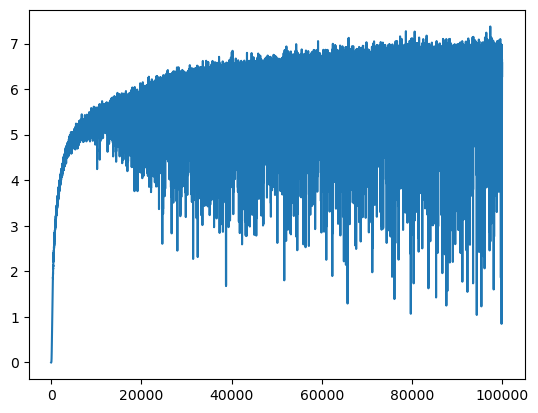

In [148]:
# plt.plot(result)
plt.plot(result_entropy[0])
# plt.plot(result_explicit_plus_Z[0])
# plt.plot(result_explicit[0])
# plt.plot(result_pretrainX[0])
# plt.plot(result_explicit[0])

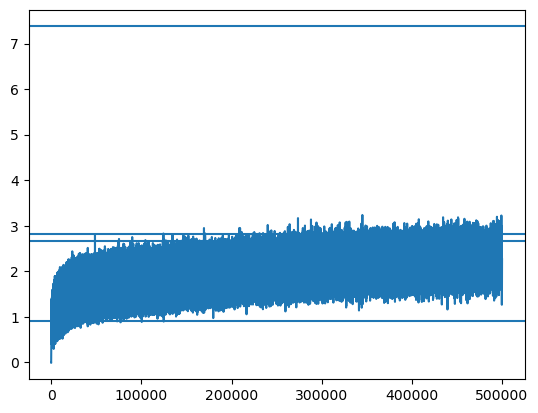

In [138]:
plt.plot(result)
plt.axhline(np.max(result_pretrainX[0]))
plt.axhline(np.max(result_explicit[0]))
plt.axhline(np.max(result_explicit_plus_Z[0]))
plt.axhline(np.max(result_entropy[0]))

In [ ]:
np.max(result_explicit_plus_Z[0]), np.max(result_explicit[0]), np.max(result_entropy)

(2.8290417, 2.6582675, 6.891037)